# 0-Libraries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay, balanced_accuracy_score
#from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer, PowerTransformer
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from keras.optimizers import Adam
#from keras.backend import expand_dims
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.layers import Activation, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, BatchNormalization, SpatialDropout1D

In [47]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

# 1- Load Data

In [48]:
s_aureus = pd.read_csv('e_coli_driams_b_2000_20000Da_v2 (1).csv')
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19988,19991,19994,19997,code,species,Ciprofloxacin,Ceftriaxone,Cefepime,Piperacillin-Tazobactam
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,21.5,6.500000,4.666667,17.585859,dcd5aa31-b254-4961-b69f-ccc8c0572b27,Escherichia coli,0.0,0.0,0.0,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,21.0,15.000000,26.500000,21.736842,dfcb7221-e4f8-4a39-b661-7e439f19e93d,Escherichia coli,0.0,0.0,0.0,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,17.0,17.000000,30.000000,19.125000,d5bb4389-5053-4107-9c05-bfed9e9159c9,Escherichia coli,0.0,0.0,0.0,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.0,339.500000,359.000000,311.746032,4e14943f-ae22-42ed-aef5-65430470dcfa,Escherichia coli,0.0,0.0,0.0,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,32.5,48.333333,66.500000,39.230769,617f14d0-86b1-4c28-8995-b02006a85e81,Escherichia coli,1.0,1.0,1.0,1.0


# Preprocessing Data

In [49]:
s_aureus = s_aureus.drop(columns=['code','species', 'Ceftriaxone', 'Cefepime', 'Piperacillin-Tazobactam'])
s_aureus.dropna(axis=0, how="any", inplace=True)

In [50]:
s_aureus.head()

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.0,42.666667,15.000000,21.5,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.0,18.000000,17.000000,21.0,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.5,14.500000,13.666667,17.0,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.0,300.500000,311.000000,299.0,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.0,37.333333,21.000000,32.5,48.333333,66.500000,39.230769,1.0


In [51]:
s_aureus

,2000,2003,2006,2009,2012,2015,2018,2021,2024,2027,...,19973,19976,19979,19982,19985,19988,19991,19994,19997,Ciprofloxacin
0,1067.142857,1251.714286,1310.571429,1021.142857,1315.625000,974.000000,936.857143,853.571429,936.142857,1044.285714,...,19.666667,20.000000,23.000000,42.666667,15.000000,21.500000,6.500000,4.666667,17.585859,0.0
1,1872.857143,1677.285714,2035.714286,2086.250000,1930.571429,2017.142857,1856.857143,1655.857143,1547.142857,1713.000000,...,32.000000,29.666667,30.000000,18.000000,17.000000,21.000000,15.000000,26.500000,21.736842,0.0
2,3258.142857,3209.428571,3068.571429,3162.428571,3275.000000,3324.571429,2999.000000,2970.500000,3213.000000,3205.571429,...,19.666667,20.000000,23.500000,14.500000,13.666667,17.000000,17.000000,30.000000,19.125000,0.0
3,18912.571429,19530.571429,19464.875000,19098.714286,18994.714286,18936.285714,19208.571429,19417.571429,19486.857143,19048.625000,...,299.000000,269.333333,282.000000,300.500000,311.000000,299.000000,339.500000,359.000000,311.746032,0.0
4,1685.000000,1537.428571,1283.714286,1472.285714,1370.142857,1402.142857,1397.500000,1422.142857,1725.285714,3386.714286,...,25.000000,34.000000,33.000000,37.333333,21.000000,32.500000,48.333333,66.500000,39.230769,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,1933.285714,1956.500000,2012.571429,1882.000000,1955.142857,1951.285714,1943.714286,2055.125000,1928.857143,1687.571429,...,140.500000,144.500000,102.666667,123.500000,113.500000,121.000000,126.666667,147.500000,122.560748,1.0
209,7296.714286,6215.714286,6115.500000,6069.000000,6585.857143,6207.857143,5809.142857,5879.142857,6068.714286,8413.125000,...,163.000000,191.500000,151.000000,180.666667,188.500000,163.500000,183.000000,173.000000,178.163462,1.0
210,2604.500000,2626.857143,2614.857143,2408.142857,2628.428571,2723.571429,2561.142857,2282.000000,2479.375000,2511.571429,...,21.000000,4.000000,11.500000,20.000000,19.500000,19.000000,10.500000,4.666667,13.857143,1.0
211,1341.142857,1190.000000,1399.142857,1469.000000,1126.000000,1049.428571,958.857143,1092.000000,1206.857143,1211.000000,...,18.000000,21.500000,15.666667,18.000000,18.000000,22.666667,17.500000,17.000000,20.863636,0.0


In [52]:
bacteria = s_aureus.columns[-1]

In [53]:
X = s_aureus.iloc[:, 0:6000].values  # variables independientes (espectros de masa)
y = s_aureus.iloc[:, 6000].values    # variable dependientes (resistencia a ciprofloxacin)
X = np.asarray(X).astype(np.float32)
y = np.asarray(y).astype(np.float32)


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

## Enfoque en clase minoritaria

In [55]:
minority_class = s_aureus[s_aureus[bacteria] == 1].drop(columns=[bacteria])


In [56]:
etiquetas = s_aureus[s_aureus[bacteria] == 1].iloc[:, 6000].values

Diffusion model


In [57]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [58]:
torch.manual_seed(42)
np.random.seed(42)

In [59]:
# Preprocesamiento
scaler = StandardScaler()
scaled_data = scaler.fit_transform(X_train)

In [60]:
# Modelo de Difusión
class DiffusionModel(nn.Module):
    def __init__(self, input_dim):
        super(DiffusionModel, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # Regularización Dropout
            nn.Linear(32, input_dim)
        )


    def forward(self, x):
        return self.model(x)


In [61]:
# Función de ruido (Scheduler)
def add_noise(data, timesteps, noise_scale=1.0):
    noise = np.random.normal(0, noise_scale, data.shape) * np.sqrt(timesteps / 100)
    noisy_data = data + noise
    return noisy_data, noise


In [62]:
# Configuración del modelo
input_dim = scaled_data.shape[1]
model = DiffusionModel(input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # O Huber Loss


In [63]:
# Scheduler de tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)


In [64]:
# Entrenamiento
scaled_data_tensor = torch.tensor(scaled_data, dtype=torch.float32)
epochs = 1000
losses = []  # Para guardar la pérdida por época

for epoch in range(epochs):
    timesteps = np.random.randint(1, 100)
    noisy_data, noise = add_noise(scaled_data, timesteps)
    noisy_data_tensor = torch.tensor(noisy_data, dtype=torch.float32)
    noise_tensor = torch.tensor(noise, dtype=torch.float32)

    optimizer.zero_grad()
    predicted_noise = model(noisy_data_tensor)
    loss = loss_fn(predicted_noise, noise_tensor)
    loss.backward()
    optimizer.step()
    scheduler.step()  # Actualiza la tasa de aprendizaje

    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item()}")


Epoch 0/1000 - Loss: 0.257081538438797
Epoch 100/1000 - Loss: 0.3211827874183655
Epoch 200/1000 - Loss: 0.27323541045188904
Epoch 300/1000 - Loss: 0.19250783324241638
Epoch 400/1000 - Loss: 0.3080591857433319
Epoch 500/1000 - Loss: 0.2975468039512634
Epoch 600/1000 - Loss: 0.06488087773323059
Epoch 700/1000 - Loss: 0.37196409702301025
Epoch 800/1000 - Loss: 0.20573703944683075
Epoch 900/1000 - Loss: 0.36873534321784973


In [65]:
# Generación de Datos Sintéticos
def generate_synthetic_data(model, num_samples, input_dim):
    model.eval()
    with torch.no_grad():
        synthetic_data = np.random.normal(0, 1, (num_samples, input_dim))
        for t in range(100, 0, -1):  # Reverse diffusion
            synthetic_data = synthetic_data - model(torch.tensor(synthetic_data, dtype=torch.float32)).numpy() * (t / 100)
        return synthetic_data

In [66]:
print(pd.Series(y_train).value_counts())

0.0    123
1.0     47
Name: count, dtype: int64


In [67]:
pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1]

76

In [68]:

synthetic_data = generate_synthetic_data(model, pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1], input_dim)
synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)


In [69]:
synthetic_data_rescaled.shape

(76, 6000)

In [70]:

# Cambiar el tipo de datos a float32
synthetic_samples_numpy = synthetic_data_rescaled.astype(np.float32)

# Mostrar las muestras generadas
synthetic_samples_numpy.shape

(76, 6000)

In [71]:
X_train_resampled = np.concatenate([X_train,synthetic_samples_numpy])

In [72]:
X_train_resampled.shape

(246, 6000)

In [73]:
ones_array = np.ones(pd.Series(y_train).value_counts()[0]-pd.Series(y_train).value_counts()[1])
y_train_resampled = np.concatenate([y_train,ones_array])
y_train_resampled.shape

(246,)

## Termino oversampling

In [74]:
scaler=Normalizer(norm='max')
sc_X = scaler
X_train = sc_X.fit_transform(X_train_resampled)
X_test = sc_X.transform(X_test)

In [75]:
sample_size = X_train.shape[0] # numero de muestras en el set de datos
time_steps  = X_train.shape[1] # numero de atributos en el set de datos
input_dimension = 1            #

X_train_reshaped = X_train.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [76]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001)
early_st = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

n_timesteps = X_train_reshaped.shape[1] #
n_features  = X_train_reshaped.shape[2] #

In [77]:
print(pd.Series(y_train_resampled).value_counts())


0.0    123
1.0    123
Name: count, dtype: int64


# Create and fit DeepAMR model

In [78]:
model = Sequential(name="Modelo_s_aureus_ciprofloxacin")
init_mode = 'normal'
model.add(Conv1D(filters=(64), kernel_size=(17), input_shape = (n_timesteps,n_features), name='Conv_1'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_1"))

model.add(Conv1D(filters=(128), kernel_size=(9),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name='Conv_2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_2"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode,kernel_regularizer=regularizers.l2(0.0001),   name='Conv_3'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_3"))

model.add(Conv1D(filters=(256), kernel_size=(5),kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),   name='Conv_4'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2, name="MaxPooling1D_4"))

model.add(Flatten())
model.add(Dropout(0.65))
model.add(Dense(256, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_0"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001), name="fully_connected_1"))
model.add(Dense(64, activation='relu',kernel_initializer=init_mode, kernel_regularizer=regularizers.l2(0.0001),  name="fully_connected_2"))
model.add(Dense(n_features, activation='sigmoid', name="OUT_Layer"))

model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy',  metrics=METRICS)
model.summary()

Model: "Modelo_s_aureus_ciprofloxacin"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_1 (Conv1D)             (None, 5984, 64)          1152      
                                                                 
 batch_normalization_4 (Batc  (None, 5984, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 5984, 64)          0         
                                                                 
 MaxPooling1D_1 (MaxPooling1  (None, 2992, 64)         0         
 D)                                                              
                                                                 
 Conv_2 (Conv1D)             (None, 2984, 128)         73856     
                                                                 
 batch_normalization_5 (Batc  (None, 

In [79]:
history = model.fit(X_train_reshaped, y_train_resampled, epochs=200, batch_size=10, verbose=1, validation_split=0.1, callbacks=[reduce_lr,early_st])

Epoch 1/200
23/23 [==============================] - 3s 50ms/step - loss: 6.9902 - tp: 50.0000 - fp: 34.0000 - tn: 89.0000 - fn: 48.0000 - accuracy: 0.6290 - precision: 0.5952 - recall: 0.5102 - auc: 0.6607 - prc: 0.6556 - val_loss: 6.9241 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 25.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 2/200
23/23 [==============================] - 1s 24ms/step - loss: 6.6876 - tp: 59.0000 - fp: 24.0000 - tn: 99.0000 - fn: 39.0000 - accuracy: 0.7149 - precision: 0.7108 - recall: 0.6020 - auc: 0.7475 - prc: 0.7720 - val_loss: 6.9726 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 0.0000e+00 - val_fn: 25.0000 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.0000e+00 - val_prc: 1.0000 - lr: 1.0000e-04
Epoch 3/200
23/23 [==============================] - 1s 24ms/step - loss: 6.5732 - t

# Evaluate the model

In [80]:
y_pred  = model.predict(X_test_reshaped)
y_pred = (y_pred>0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)

2/2 [==============================] - 0s 8ms/step
[[31  0]
 [12  0]]


In [81]:
print("balanced acuracy:", balanced_accuracy_score(y_test, y_pred))

balanced acuracy: 0.5


In [82]:
target_names=["0","1"]
print(classification_report(y_test, y_pred, target_names=target_names))

train_predictions_baseline = model.predict(X_train_reshaped, batch_size=10)
test_predictions_baseline = model.predict(X_test_reshaped, batch_size=10)

baseline_results = model.evaluate(X_test_reshaped, y_test, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

              precision    recall  f1-score   support

           0       0.72      1.00      0.84        31
           1       0.00      0.00      0.00        12

    accuracy                           0.72        43
   macro avg       0.36      0.50      0.42        43
weighted avg       0.52      0.72      0.60        43

14/25 [===============>..............] - ETA: 0s

/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hpinto/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5/5 [==============================] - 0s 4ms/step
loss :  6.768890380859375
tp :  0.0
fp :  0.0
tn :  31.0
fn :  12.0
accuracy :  0.7209302186965942
precision :  0.0
recall :  0.0
auc :  0.47311824560165405
prc :  0.27358388900756836



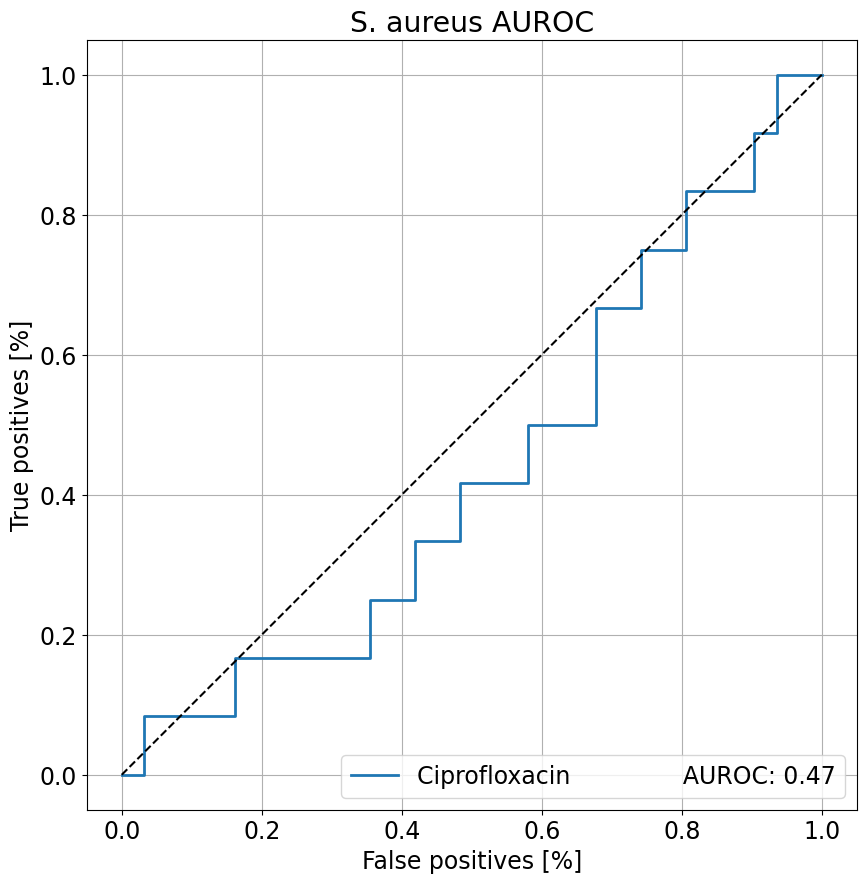

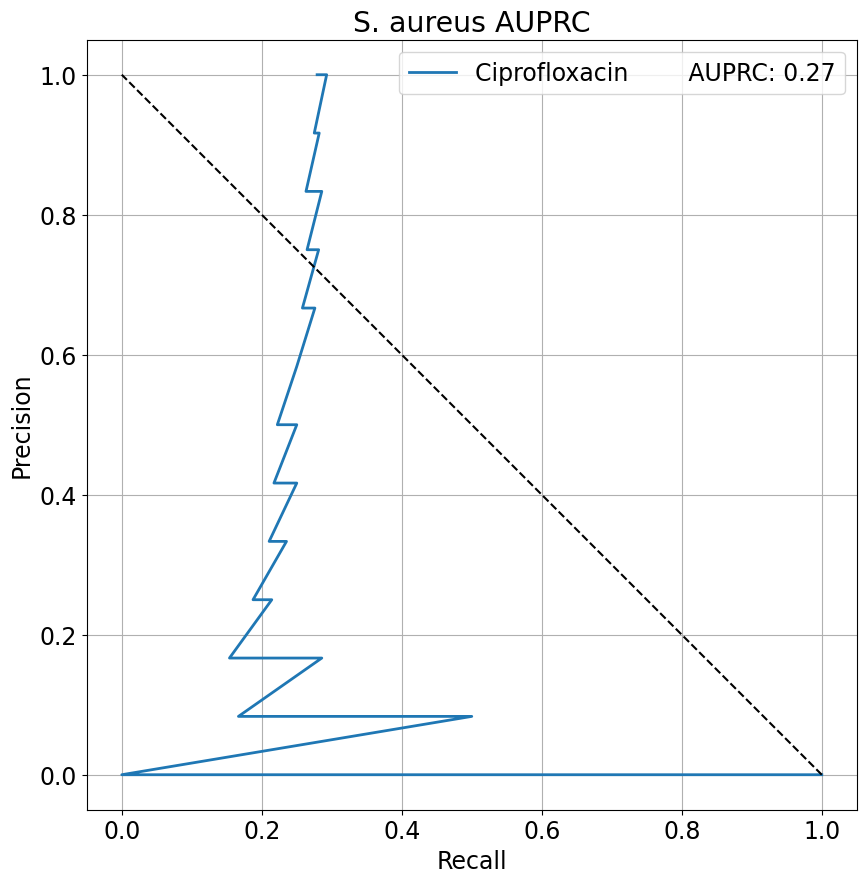

In [83]:
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams.update({'font.size': 17})
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.title('E. coli CNN')
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.title('S. aureus AUROC')

  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
plot_roc("Ciprofloxacin               AUROC: %0.2f" % baseline_results[8], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='lower right')
plt.savefig('s_aureus_auroc.png', bbox_inches='tight')
plt.show()

def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.title('S. aureus AUPRC')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot([1, 0], [0, 1], 'k--')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

plot_prc("Ciprofloxacin        AUPRC: %0.2f" % baseline_results[9], y_test, test_predictions_baseline, color=colors[0])

plt.legend(loc='upper right')
plt.savefig('s_aureus_auprc.png', bbox_inches='tight')
plt.show()